# Co-Training

Podobnie jak w przykładzie do podejścia Self-Training, zacznijmy od załadowania i przetasowania zestawu danych:

In [1]:
from sklearn.datasets import load_wine
from sklearn.utils import shuffle
import numpy as np

wine = load_wine()
X, Y = shuffle(wine['data'], wine['target'], random_state=1000)

In [2]:
print(X[0:5])
print('Ilosc cech to:',X.shape[1])
print('\n')
print(Y[0:5])
print('Klasy to:', np.unique(Y))

[[1.363e+01 1.810e+00 2.700e+00 1.720e+01 1.120e+02 2.850e+00 2.910e+00
  3.000e-01 1.460e+00 7.300e+00 1.280e+00 2.880e+00 1.310e+03]
 [1.311e+01 1.010e+00 1.700e+00 1.500e+01 7.800e+01 2.980e+00 3.180e+00
  2.600e-01 2.280e+00 5.300e+00 1.120e+00 3.180e+00 5.020e+02]
 [1.373e+01 4.360e+00 2.260e+00 2.250e+01 8.800e+01 1.280e+00 4.700e-01
  5.200e-01 1.150e+00 6.620e+00 7.800e-01 1.750e+00 5.200e+02]
 [1.388e+01 5.040e+00 2.230e+00 2.000e+01 8.000e+01 9.800e-01 3.400e-01
  4.000e-01 6.800e-01 4.900e+00 5.800e-01 1.330e+00 4.150e+02]
 [1.329e+01 1.970e+00 2.680e+00 1.680e+01 1.020e+02 3.000e+00 3.230e+00
  3.100e-01 1.660e+00 6.000e+00 1.070e+00 2.840e+00 1.270e+03]]
Ilosc cech to: 13


[0 1 2 2 0]
Klasy to: [0 1 2]


Zbiór danych Wine zawiera dane chemiczne dotyczące różnych win (178 punktów danych). W szczególności istnieje 13 cech. Zakładamy, że możliwe jest przewidzieć klasę przy użyciu dwóch 'widoków' zawierających pierwsze 7 cech i pozostałe 6 cech (nie jest ważne, czy jest to poprawne chemicznie, traktujemy to jedynie jako przykład, w prawdziwym scenariuszu analityk danych oczywiście nigdy nie powinien decydować się na arbitralny podział cech, ponieważ tylko ekspert  może mieć specjalistyczną wiedzę wymaganą do dokonania rozsądnego podziału).

W tym przypadku załóżmy, że mamy 20 oznaczonych punktów i 158 nieoznaczonych:

In [3]:
nb_samples = X.shape[0]
nb_labeled = 20
nb_unlabeled = nb_samples - nb_labeled
nb_unlabeled_samples = 2

feature_cut = 7

X_unlabeled = X[-nb_unlabeled:]

X_labeled = X[:nb_labeled]
Y_labeled = Y[:nb_labeled]

X_labeled_1 = X_labeled[:, 0:feature_cut]
X_labeled_2 = X_labeled[:, feature_cut:]

Tablice <i>X_labeled_1/2</i> to nasze dwa różne "widoki". Te zbiory treningowe współdzielą tę samą tablicę <i>Y_labeled</i>. Podobnie jak w przykładzie Self-Training, zamierzamy zastosować znany nam Naiwny Klasyfikatory Bayesowski (można inną metodę taką jak regresja logistyczna). Pierwszym krokiem jest uczemie modelu opartego tylko na oznaczonych danych, aby uzyskać pewnego rodzaju punkt odniesienia:

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

nb0 = GaussianNB()
nb0.fit(X_labeled, Y_labeled)
print(classification_report(Y, nb0.predict(X), target_names=wine['target_names']))

              precision    recall  f1-score   support

     class_0       1.00      0.51      0.67        59
     class_1       0.68      1.00      0.81        71
     class_2       1.00      0.92      0.96        48

    accuracy                           0.81       178
   macro avg       0.89      0.81      0.81       178
weighted avg       0.87      0.81      0.81       178



Funkcja <i>classification_report</i> z biblioteki <i>scikit-learn</i> dostarcza kompleksowego raportu, który zawiera różne metryki oceny wydajności modelu klasyfikacji.

Precyzja (Precision): Precyzja to miara tego, ile z przewidzianych instancji pozytywnych jest rzeczywiście instancjami prawdziwie pozytywnymi. W raporcie znajdują się wartości precyzji dla każdej klasy w zbiorze danych. $$\frac{TP}{TP+FP}$$

Czułość (Recall): Czułość, znana również jako współczynnik prawdziwie pozytywnych, mierzy, ile z prawdziwych instancji pozytywnych jest prawidłowo zidentyfikowanych. W raporcie znajdują się wartości czułości dla każdej klasy.$$\frac{TP}{TP+FN}$$

Wsparcie (Support): Wsparcie to liczba wystąpień w każdej z klas w zbiorze danych.

Macro avg: Średnia dla wszystkich klas

Wynik potwierdza, że nawet mała próbka może przynieść dobre wyniki, z średnią precyzją około 0,89 i nieco gorszą czułością. 

Możemy teraz przejść do podejścia Co-Training, wybierając <i>n_unlabeled_samples</i> punktów (tych o najwyższej "ufności") dla każdego klasyfikatora w każdej iteracji:

In [5]:
#Caly proces Co-Training


nb1 = None
nb2 = None
nt=0

while X_labeled_1.shape[0] <= nb_samples:
    nt += 1
    nb1 = GaussianNB()
    nb1.fit(X_labeled_1, Y_labeled)

    nb2 = GaussianNB()
    nb2.fit(X_labeled_2, Y_labeled)

    if X_labeled_1.shape[0] == nb_samples:
        break

    probs1 = nb1.predict_proba(X_unlabeled[:, 0:feature_cut])
    top_confidence_idxs1 = np.argsort(np.max(probs1, axis=1))[::-1]
    selected_idxs1 = top_confidence_idxs1[0:nb_unlabeled_samples]

    probs2 = nb2.predict_proba(X_unlabeled[:, feature_cut:])
    top_confidence_idxs2 = np.argsort(np.max(probs2, axis=1))[::-1]
    selected_idxs2 = top_confidence_idxs2[0:nb_unlabeled_samples]

    selected_idxs = list(selected_idxs1) + list(selected_idxs2)

    X_new_labeled = X_unlabeled[selected_idxs]
    X_new_labeled_1 = X_unlabeled[selected_idxs1, 0:feature_cut]
    X_new_labeled_2 = X_unlabeled[selected_idxs2, feature_cut:]

    Y_new_labeled_1 = nb1.predict(X_new_labeled_1)
    Y_new_labeled_2 = nb2.predict(X_new_labeled_2)

    X_labeled_1 = np.concatenate((X_labeled_1, X_new_labeled[:, 0:feature_cut]), axis=0)
    X_labeled_2 = np.concatenate((X_labeled_2, X_new_labeled[:, feature_cut:]), axis=0)
    Y_labeled = np.concatenate((Y_labeled, Y_new_labeled_1, Y_new_labeled_2), axis=0)

    X_unlabeled = np.delete(X_unlabeled, selected_idxs, axis=0)

In [16]:
#Pierwsza iteracja procesu - posluzy nam w zrozumieniu algorytmu


nb1 = None #przechowuje pierwszy klasyfikator Gaussian Naive Bayes
nb2 = None

for i in range(1):    
    nb1 = GaussianNB() #tworzymy pierwszy klasyfikator
    nb1.fit(X_labeled_1, Y_labeled) #trenujemy na zbiorze oznaczonym

    nb2 = GaussianNB() 
    nb2.fit(X_labeled_2, Y_labeled)
    
    if X_labeled_1.shape[0] == nb_samples: #sprawdzamy czy wszystkie probki sa juz oznaczone
        break #wtedy proces Co-Training sie konczy

    probs1 = nb1.predict_proba(X_unlabeled[:, 0:feature_cut])
    #uzywamy klasyfikatora do predykcji prawdopodobienstw klas nieoznakowanego zbioru na pierwszych 7 cechach
    #dla kazdego punktu nieoznaczonego zwraca tablice 3 prawdopodobienstw
    print(probs1)
    print('\n')
    
    top_confidence_idxs1 = np.argsort(np.max(probs1, axis=1))[::-1]
    #dla kazdego punktu liczymy maksymalne prawdopodobienstwo sposrod klas (z tablicy probs), 
    #a nastepnie sortujemy malejaco
    print(top_confidence_idxs1)
    
    selected_idxs1 = top_confidence_idxs1[0:nb_unlabeled_samples]
    #bierzemy pierwsze nb_unlabeled_samples indeksow
    print(selected_idxs1)
    print('\n')
    
    #to samo dla drugiego klasyfikatora
    probs2 = nb2.predict_proba(X_unlabeled[:, feature_cut:])
    print(probs2)
    print('\n')
    
    top_confidence_idxs2 = np.argsort(np.max(probs2, axis=1))[::-1]
    print(top_confidence_idxs2)
    
    selected_idxs2 = top_confidence_idxs2[0:nb_unlabeled_samples]
    print(selected_idxs2)
    print('\n')   

    selected_idxs = list(selected_idxs1) + list(selected_idxs2)
    #laczymy 'pewne' predykcje
    print('\n')
    print(selected_idxs)

    X_new_labeled = X_unlabeled[selected_idxs]
    
    X_new_labeled_1 = X_unlabeled[selected_idxs1, 0:feature_cut]
    #bierzemy cechy dla pierwszego widoku dla wybranych indeksow 1 klasyfikatora
    
    X_new_labeled_2 = X_unlabeled[selected_idxs2, feature_cut:]
    #bierzemy cechy dla drugiego widoku dla wybranych indeksow 2 klasyfikatora
    
    
    Y_new_labeled_1 = nb1.predict(X_new_labeled_1)
    #przewidujemy etykiety dla nowego zbioru na podstawie pierwszego widoku
    print(X_new_labeled_1)
    print(Y_new_labeled_1)
    print('\n')
    
    Y_new_labeled_2 = nb2.predict(X_new_labeled_2)
    print(X_new_labeled_2)
    print(Y_new_labeled_2)
    print('\n')

    X_labeled_1 = np.concatenate((X_labeled_1, X_new_labeled[:, 0:feature_cut]), axis=0)
    #dolaczamy nowo oznakowane punkty do zbioru treningowego pierwszego widoku
    
    X_labeled_2 = np.concatenate((X_labeled_2, X_new_labeled[:, feature_cut:]), axis=0)
    #dolaczamy nowo oznakowane punkty do zbioru treningowego drugiego widoku
    
    Y_labeled = np.concatenate((Y_labeled, Y_new_labeled_1, Y_new_labeled_2), axis=0)
    #dolaczamy odpowiadajace etykiety
    
    X_unlabeled = np.delete(X_unlabeled, selected_idxs, axis=0)
    #usuwamy juz oznaczone punkty ze zbioru nieoznaczonych

[[2.34857315e-187 3.08526274e-002 9.69147373e-001]
 [5.39165343e-171 5.13296678e-002 9.48670332e-001]
 [9.99983998e-001 1.60018790e-005 1.18649409e-018]
 [9.99313227e-001 6.86773489e-004 7.82747269e-017]
 [1.25134151e-030 9.99999955e-001 4.50247087e-008]
 [6.63196017e-125 9.97641278e-001 2.35872249e-003]
 [8.73982571e-102 9.99999973e-001 2.70799001e-008]
 [9.58132633e-013 1.00000000e+000 2.14290836e-014]
 [1.42188240e-014 9.99999981e-001 1.94895824e-008]
 [8.09418118e-128 2.78115838e-002 9.72188416e-001]
 [2.60253631e-048 1.00000000e+000 3.65517427e-023]
 [1.25519761e-076 9.81803982e-001 1.81960185e-002]
 [2.42572753e-009 9.99999996e-001 1.23345748e-009]
 [3.41564205e-009 1.19542906e-001 8.80457091e-001]
 [2.73608322e-021 9.99999000e-001 9.99827620e-007]
 [1.40257646e-227 7.48830353e-004 9.99251170e-001]
 [9.21375866e-157 1.10933152e-001 8.89066848e-001]
 [1.93826496e-024 9.99999999e-001 8.55417292e-010]
 [4.01413501e-039 1.00000000e+000 1.21710183e-011]
 [8.79549270e-004 9.99120451e-0

In [20]:
print('Pierwszy klasyfikator: ',probs1[[36,81]])
print('\n')
print('Drugi klasyfikator: ',probs2[[24,106]])

Pierwszy klasyfikator:  [[9.38675210e-27 1.00000000e+00 9.31951762e-25]
 [4.99400548e-22 1.00000000e+00 1.32251829e-17]]


Drugi klasyfikator:  [[1.16843025e-15 1.00000000e+00 5.32001839e-64]
 [1.00000000e+00 2.62288255e-13 4.48675177e-48]]


Procedura nie różni się zbytnio od Self-Training, ale mamy dwa różne klasyfikatory. Zacznijmy od oceny pierwszego z nich:

In [6]:
print(classification_report(Y, nb1.predict(X[:, 0:feature_cut]), target_names=wine['target_names']))

              precision    recall  f1-score   support

     class_0       1.00      0.75      0.85        59
     class_1       0.77      0.97      0.86        71
     class_2       0.95      0.88      0.91        48

    accuracy                           0.87       178
   macro avg       0.91      0.86      0.87       178
weighted avg       0.89      0.87      0.87       178



Jak można zauważyć, pierwszy klasyfikator osiągnął lepszą średnią precyzję przy jednak gorszych wynikach dla drugiej klasy. Wynik jest jednak lepszy niż w podejściu wstępnym, co częściowo potwierdza naszą początkową hipotezę o pozytywnym wpływie nieoznakowanych próbek, nawet przy ograniczeniu ilości cech do predykcji (tutaj 7 pierwszych).

Oceńmy teraz drugi klasyfikator:


In [37]:
print(classification_report(Y, nb2.predict(X[:, feature_cut:]),target_names=wine['target_names']))

              precision    recall  f1-score   support

     class_0       1.00      0.71      0.83        59
     class_1       0.78      0.97      0.87        71
     class_2       0.96      0.96      0.96        48

    accuracy                           0.88       178
   macro avg       0.91      0.88      0.89       178
weighted avg       0.90      0.88      0.88       178



Ponownie, ostateczny wynik jest lepszy od podejścia wstępnego. Możemy stwierdzić, że klasa 1 jest najbardziej problematyczna. Wynik ten może być bezpośrednio związany z większą ilością punktów w tej klasie (71 punktów), które może prowadzić klasyfikator do błędnego przypisania większej liczby punktów do tej klasy.

Dodatkowo ten algorytm wykonuje mniej iteracji niż procedura Self-Training (jednak oczywiście wykorzystuje dwa klasyfikatory w każdej iteracji).

In [8]:
print('Liczba iteracji: ', nt)

Liczba iteracji:  40


Można zatem powiedzieć, że w szczególnych przypadkach, kiedy mamy do czynienia z danymi wysokowymiarowymi, które możemy w pewien sposób podzielić, podejście Co-Training będzie dawać lepsze efekty niż Self-Training. Jest tak, gdyż w podejściu Co-Training podczas każdej iteracji oba klasyfikatory proponują etykiety o największej 'ufności, zatem żaden z dwóch modeli nie jest zmuszony (przynajmniej dopóki nie ma wystarczająco małej liczby pozostałych próbek bez etykiet) do etykietowania punktów o niskiej 'ufności' (w przeciwieństwie do podejścia Self-Training). Co-Training unika ryzykownych decyzji, pozwalając, aby etykietowany zbiór danych rósł, starając się utrzymać optymalny poziom 'ufności' (który oczywiście spada po dodaniu najtrudniejszych punktów).
<br>

Proces ten pokazano na poniższym rysunku, gdzie "ryzykowny" punkt danych pozostaje nieoznakowany, dopóki nie jest konieczne jego dodanie.

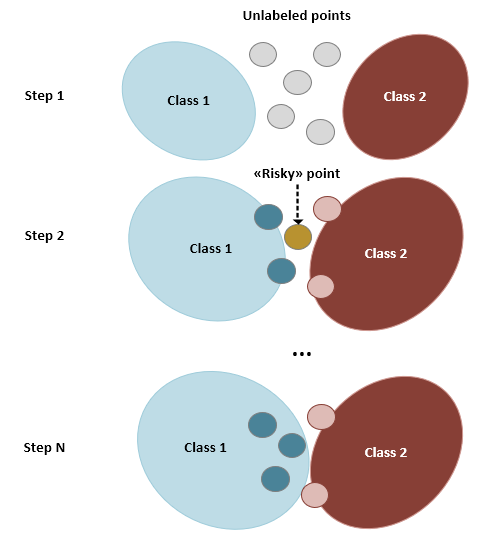

## Podsumowanie

Jeśli mamy możliwość podziału naszego zbioru, podejście oparte na Co-Trainingu może być dobrą alternatywą w porównaniu z metodą Self-Training. Dzięki dwóm klasyfikatorom, zmniejsza ono prawdpodobieństwo błędnego zklasyfikowania próbki.